**recsys-cluster-loss**

Example of cluster analysis in the context of recommendation systems.
Users who receive recommendations will be grouped based on the individual fairness measure of those recommendations.
The objective is to analyze whether there is any type of injustice of non-obvious user groups, that is, groups that cannot be configured based on some explicit user characteristic (variable) (for example: gender, age, etc.) .

Two methods of grouping will be applied:
1. Hierarchical clustering (tree clustering - dendrogram)
2. Non-hierarchical grouping by breakdown (grouping by k-Means)

In this file we are analyzing the possible groupings considering the following variable(s):
- Loss: individual unfairness

Recommendation system: generating the recommendation matrix and calculating individual fairness

In [1]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance
from UserFairness import GroupLossVariance

In [4]:
# reading data from 3883 movies and 6040 users 
Data_path = 'recsys-cluster-loss/data/Books'
n_users=  300
n_items= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_items = False # True: to use movies with more ratings; False: otherwise

In [5]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [6]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [7]:
recsys = RecSys(n_users, n_items, top_users, top_items, l, theta, k)

In [8]:
X, users_info, items_info = recsys.read_books(n_users, n_items, top_users, top_items, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [9]:
users_info

,Location,Age,NR
1,"nyc, new york, usa",18,NaN
2,"stockton, california, usa",58,NaN
3,"moscow, yukon territory, russia",51,NaN
4,"porto, v.n.gaia, portugal",73,NaN
5,"farnborough, hants, united kingdom",52,NaN
...,...,...,...
29996,"park forest, illinois, usa",65,NaN
29997,"calgary, alberta, canada",38,NaN
29998,"loxley, alabama, usa",59,NaN
29999,"salina, kansas, usa",50,NaN


In [10]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [11]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [12]:
losses

UserID
11676    1.406421
16795    1.193364
2110     0.908189
2030     0.186139
1733     0.424401
           ...   
2559     0.436580
2644     0.448597
2651     0.448835
2653     0.500000
2678     0.500000
Length: 300, dtype: float64

In [13]:
df = pd.DataFrame(columns=['Location', 'Age', 'Loss'])
df['Location'] = users_info['Location']
df['Age'] = users_info['Age']
df['NR'] = users_info['NR']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) # eliminating rows with empty values in the 'Loss' column
df

,Location,Age,Loss,NR
254,"minneapolis, minnesota, usa",34,0.370001,4.0
638,"san diego, california, usa",51,0.600132,5.0
882,"berkeley, california, usa",52,2.201142,5.0
929,"king of prussia, ,",35,0.482739,2.0
1131,"berkeley, ,",28,0.950329,20.0
...,...,...,...,...
28634,"bad axe, michigan, usa",69,0.432956,13.0
28647,"aspinwall, pennsylvania, usa",18,0.793706,3.0
29209,"boca raton, florida, usa",48,2.007592,9.0
29259,"mt. airy, , usa",66,0.556470,5.0


In [14]:
df.head()

,Location,Age,Loss,NR
254,"minneapolis, minnesota, usa",34,0.370001,4.0
638,"san diego, california, usa",51,0.600132,5.0
882,"berkeley, california, usa",52,2.201142,5.0
929,"king of prussia, ,",35,0.482739,2.0
1131,"berkeley, ,",28,0.950329,20.0


In [15]:
# number of rows and columns:
df.shape

(300, 4)

In [16]:
# descriptive statistics:
df.describe()

,Age,Loss,NR
count,300.000000,300.000000,300.000000
mean,43.686667,1.029915,7.110000
std,17.518509,1.138689,17.692408
min,14.000000,0.042335,2.000000
25%,28.750000,0.438007,3.000000
50%,43.000000,0.666281,4.000000
75%,59.000000,1.289607,7.000000
max,75.000000,11.359402,294.000000


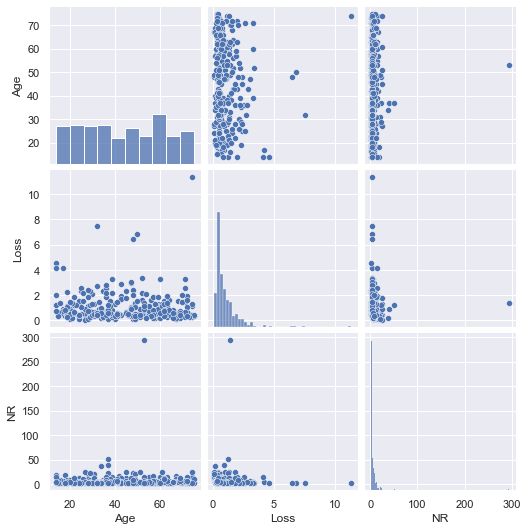

In [17]:
sns.pairplot(df)

<AxesSubplot:>

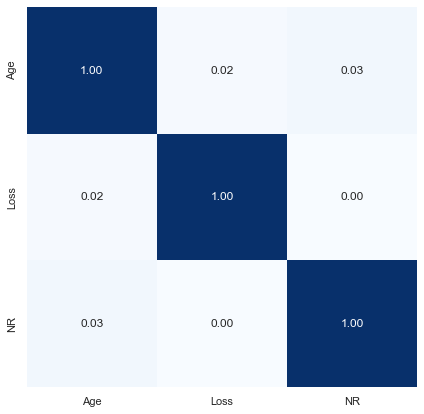

In [18]:
df = df.drop(['Location'] , axis=1) # eliminating Location (non-numeric) columns to analyze correlations

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df.columns, yticklabels=df.columns)

Hierarchical clustering (tree clustering - dendrogram)

In [19]:
# Leaving only the Loss column to perform cluster analysis
df = df.drop('Age', 1) 
df = df.drop('NR', 1) 
#df = df.drop('Loss', 1)

In [20]:
df_scaled = df.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df)

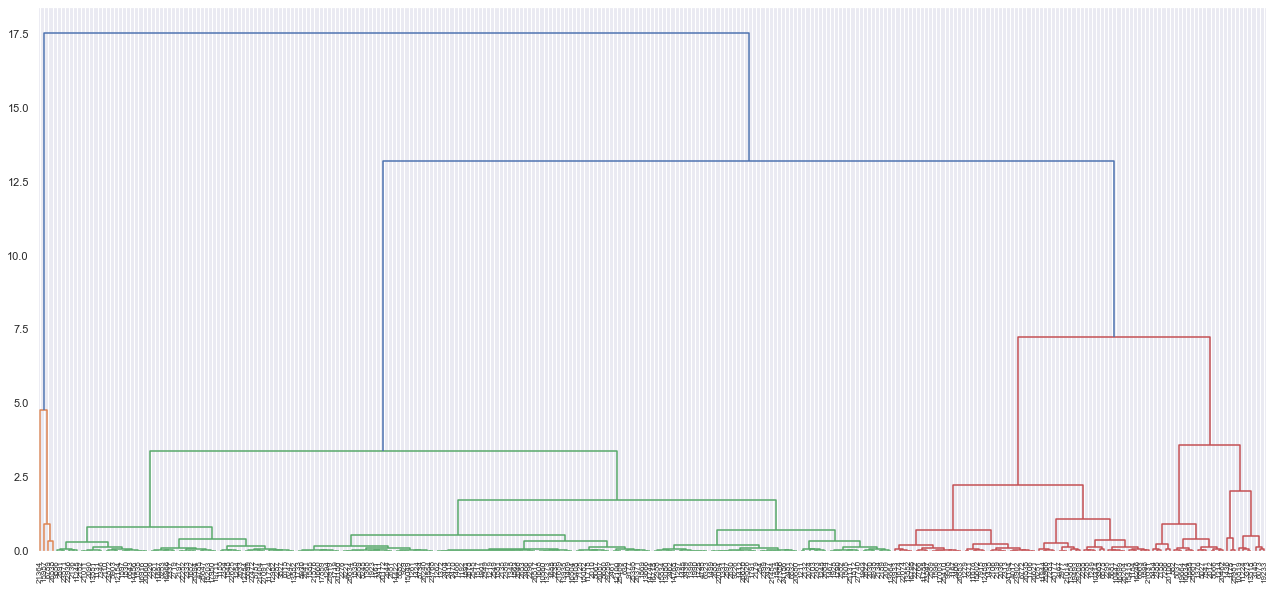

In [21]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [22]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df_scaled['cluster_agglomerative'] = cluster.fit_predict(df_scaled)

In [23]:
# descriptive statistics of groups
df_groups = df.copy()
df_groups["cluster_agglomerative"] = cluster.labels_
df_groups = df_groups.groupby("cluster_agglomerative")
df_groups.describe()

Loss                                          \
                       count      mean       std       min       25%   
cluster_agglomerative                                                  
0                       91.0  1.860547  0.748067  1.087653  1.318300   
1                        4.0  8.031913  2.262481  6.445119  6.716571   
2                      205.0  0.524571  0.229209  0.042335  0.357069   

                                                      
                            50%       75%        max  
cluster_agglomerative                                 
0                      1.595946  2.195236   4.580841  
1                      7.161566  8.476908  11.359402  
2                      0.500000  0.704576   1.050364

In [24]:

users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [882, 1167, 1178, 1184, 1214, 1249, 1279, 1376, 1435, 1436, 1558, 1596, 1674, 1706, 1898, 2012, 2036, 2106, 2139, 2222, 2255, 2288, 2295, 2313, 2385, 2406, 2589, 2766, 2977, 3145, 3167, 3363, 3371, 3373, 4017, 5027, 5037, 6073, 6251, 6563, 6575, 6772, 7158, 7283, 7286, 7841, 7915, 8066, 8454, 8681, 9908, 10314, 10447, 10819, 11224, 11676, 11788, 11944, 12489, 13518, 13552, 13850, 15418, 15602, 16246, 16599, 16634, 16795, 17003, 19233, 19493, 19664, 20106, 20462, 21014, 21031, 22074, 23547, 23902, 23933, 24194, 25410, 25601, 25966, 25981, 26535, 26621, 26883, 28177, 28204, 29209]

Cluster 1: [6789, 15957, 21364, 26538]

Cluster 2: [254, 638, 929, 1131, 1155, 1161, 1192, 1211, 1219, 1248, 1254, 1261, 1262, 1294, 1297, 1331, 1348, 1368, 1372, 1399, 1409, 1412, 1424, 1466, 1467, 1485, 1499, 1517, 1535, 1548, 1554, 1585, 1597, 1608, 1652, 1660, 1688, 1719, 1725, 1733, 1790, 1791, 1805, 1812, 1830, 1838, 1848, 1863, 1869, 1881, 1891, 1901, 1903, 1923, 1928, 1990, 2009, 2010, 2024,

Non-hierarchical grouping (K-means)

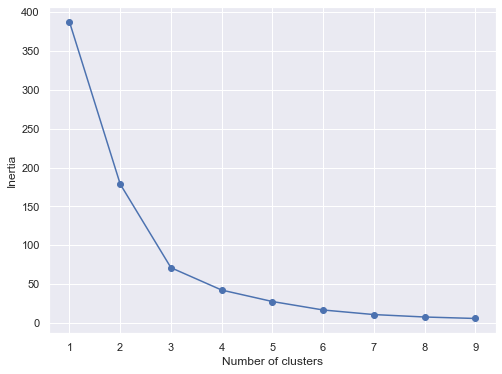

In [25]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [26]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster_kmeans'] = kmeans.fit_predict(df_scaled)

In [27]:
df_scaled

,Loss,cluster_agglomerative,cluster_kmeans
254,-0.580507,2,1
638,-0.378068,2,1
882,1.030294,0,0
929,-0.481335,2,1
1131,-0.070009,2,1
...,...,...,...
28634,-0.525127,2,1
28647,-0.207786,2,1
29209,0.860034,0,0
29259,-0.416476,2,1


In [28]:
users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [882, 1167, 1178, 1184, 1214, 1249, 1279, 1376, 1435, 1436, 1558, 1596, 1674, 1706, 1898, 2012, 2036, 2106, 2139, 2222, 2255, 2288, 2295, 2313, 2385, 2406, 2589, 2766, 2977, 3145, 3167, 3363, 3371, 3373, 4017, 5027, 5037, 6073, 6251, 6563, 6575, 6772, 7158, 7283, 7286, 7841, 7915, 8066, 8454, 8681, 9908, 10314, 10447, 10819, 11224, 11676, 11788, 11944, 12489, 13518, 13552, 13850, 15418, 15602, 16246, 16599, 16634, 16795, 17003, 19233, 19493, 19664, 20106, 20462, 21014, 21031, 22074, 23547, 23902, 23933, 24194, 25410, 25601, 25966, 25981, 26535, 26621, 26883, 28177, 28204, 29209]

Cluster 1: [6789, 15957, 21364, 26538]

Cluster 2: [254, 638, 929, 1131, 1155, 1161, 1192, 1211, 1219, 1248, 1254, 1261, 1262, 1294, 1297, 1331, 1348, 1368, 1372, 1399, 1409, 1412, 1424, 1466, 1467, 1485, 1499, 1517, 1535, 1548, 1554, 1585, 1597, 1608, 1652, 1660, 1688, 1719, 1725, 1733, 1790, 1791, 1805, 1812, 1830, 1838, 1848, 1863, 1869, 1881, 1891, 1901, 1903, 1923, 1928, 1990, 2009, 2010, 2024,

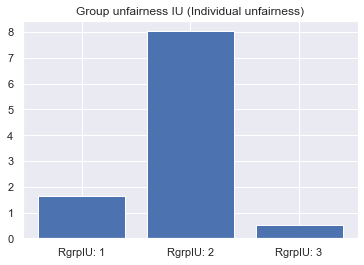

In [29]:
# G group: identifying the groups (IU: individual unfairness - the variance of the user losses)
# The configuration of groups was based in the hierarchical clustering (tree clustering - dendrogram)
# Clusters 1, 2 and 3
G = {1: [882, 1167, 1178, 1184, 1214, 1249, 1279, 1376, 1435, 1436, 1558, 1596, 1674, 1706, 1898, 2012, 2036, 2106, 2139, 2222, 2255, 2288, 2295, 2313, 2385, 2406, 2589, 2766, 2977, 3145, 3167, 3363, 3371, 3373, 4017, 5027, 5037, 6073, 6251, 6563, 6575, 6772, 7158, 7283, 7286, 7841, 7915, 8066, 8454, 8681, 9908, 10314, 10447, 10819, 11224, 11676, 11788, 11944, 12489, 13518, 13552, 13850, 15418, 15602, 16246, 16599, 16634, 16795, 17003, 19233, 19493, 19664, 20106, 20462, 21014, 21031, 22074, 23547, 23902, 23933, 24194, 25410, 25601, 25966, 25981, 26535, 26621, 26883, 28177, 28204, 29209], 2: [6789, 15957, 21364, 26538], 3: [254, 638, 929, 1131, 1155, 1161, 1192, 1211, 1219, 1248, 1254, 1261, 1262, 1294, 1297, 1331, 1348, 1368, 1372, 1399, 1409, 1412, 1424, 1466, 1467, 1485, 1499, 1517, 1535, 1548, 1554, 1585, 1597, 1608, 1652, 1660, 1688, 1719, 1725, 1733, 1790, 1791, 1805, 1812, 1830, 1838, 1848, 1863, 1869, 1881, 1891, 1901, 1903, 1923, 1928, 1990, 2009, 2010, 2024, 2030, 2033, 2041, 2046, 2084, 2090, 2103, 2110, 2132, 2134, 2135, 2136, 2152, 2179, 2189, 2197, 2238, 2276, 2281, 2287, 2296, 2326, 2333, 2337, 2349, 2354, 2358, 2363, 2389, 2399, 2404, 2411, 2415, 2437, 2439, 2461, 2462, 2466, 2470, 2481, 2545, 2549, 2552, 2559, 2597, 2622, 2630, 2644, 2651, 2653, 2678, 2688, 2719, 2891, 3827, 4221, 4785, 4795, 4938, 5582, 5899, 5903, 6115, 6242, 6323, 6532, 6543, 7125, 7346, 8067, 8187, 8245, 8253, 8680, 8734, 8930, 9177, 9226, 9856, 10560, 11245, 11657, 11718, 11724, 12100, 12154, 12784, 12982, 13080, 13273, 13551, 13582, 13664, 13666, 13935, 14422, 14456, 14744, 14768, 15049, 15408, 15834, 16504, 16718, 16916, 16966, 17859, 17950, 18082, 18203, 19711, 20060, 20172, 20180, 20680, 21011, 21356, 21404, 21484, 21576, 21659, 22094, 22252, 22625, 22936, 23571, 23768, 23872, 24186, 25131, 25395, 25409, 25919, 26057, 26240, 26371, 26517, 26620, 27091, 27472, 27740, 28594, 28634, 28647, 29259, 29526]}

glv = GroupLossVariance(X, omega, G, 1) #axis = 1 (0 rows e 1 columns)
losses_RgrpIU = glv.get_losses(X_est)

RgrpIU_groups = ['RgrpIU: 1', 'RgrpIU: 2', 'RgrpIU: 3']
plt.bar(RgrpIU_groups, losses_RgrpIU)
plt.title('Group unfairness IU (Individual unfairness)')
plt.show()